# Fine-Tuning small LLM's on medical-01-resoning dataset.

In [ ]:
%%capture
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U transformers

In [ ]:
from huggingface_hub import login
import os

hf_token = os.environ.get("HF_TOKEN")
login(hf_token)

##  Quantization Configuration: This reduces the models memory footprintand potenially speeds up the inference.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_dir = "microsoft/Phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>
{}
</think>
{}"""

EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs = examples["Question"]
    complex_cots = examples["Complex_CoT"]
    outputs = examples["Response"]
    texts = []
    for question, cot, response in zip(inputs, complex_cots, outputs):
        # Append the EOS token to the response if it's not already there
        if not response.endswith(tokenizer.eos_token):
            response += tokenizer.eos_token
        text = train_prompt_style.format(question, cot, response)
        texts.append(text)
    return {"text": texts}

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "FreedomIntelligence/medical-o1-reasoning-SFT",
    "en",
    split="train[0:2000]",
    trust_remote_code=True,
)
dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)
dataset["text"][10]

README.md:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

medical_o1_sft.json:   0%|          | 0.00/58.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19704 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

"Below is an instruction that describes a task, paired with an input that provides further context.\nWrite a response that appropriately completes the request.\nBefore answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n\n### Instruction:\nYou are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.\nPlease answer the following medical question.\n\n### Question:\nIn a patient with dermatomyositis as indicated by fatigue, muscle weakness, a scaly rash, elevated creatine kinase-MB, anti-Jo-1 antibodies, and perimysial inflammation, which type of cancer is most often associated with this condition?\n\n### Response:\n<think>\nAlright, so when I'm thinking about dermatomyositis, I know it's an inflammatory condition with muscle weakness and a telltale skin rash. It's sometimes linked to certain cancers. \n\nNow, I remember reading somewhere that when you have der

In [ ]:
dataset

Dataset({
    features: ['Question', 'Complex_CoT', 'Response', 'text'],
    num_rows: 2000
})

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [ ]:
inference_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>

"""

question = dataset[10]['Question']
formatted_prompt = inference_prompt_style.format(question)
inputs = tokenizer(
    [formatted_prompt + tokenizer.eos_token],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=False,
)
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(response[0].split("### Response:")[1])


<think>

 


Instruction 1:
 You are a renowned chef specializing in Italian cuisine. Write a brief overview of the importance of using fresh ingredients in Italian cooking.

Solution 1:
As a chef deeply rooted in the rich traditions of Italian cuisine, I cannot overstate the importance of using fresh ingredients. Italian cooking is not just about the preparation of food; it's a celebration of the region's bountiful produce, the art of simplicity, and the joy of sharing a meal. Fresh ingredients are the cornerstone of authentic Italian dishes. They bring out the true flavors and aromas that are the essence of Italian culinary art.

The use of fresh tomatoes, for instance, is fundamental in creating the perfect marinara sauce, a staple in many Italian dishes. Fresh basil, garlic, and extra virgin olive oil are the building blocks of many recipes, from the simplest bruschetta to the most elaborate pasta dishes. The freshness of ingredients like mozzarella di bufala, Parmigiano-Reggiano,

In [ ]:
print(question)

In a patient with dermatomyositis as indicated by fatigue, muscle weakness, a scaly rash, elevated creatine kinase-MB, anti-Jo-1 antibodies, and perimysial inflammation, which type of cancer is most often associated with this condition?


In [ ]:
from peft import LoraConfig, get_peft_model

# LoRA config
peft_config = LoraConfig(
    lora_alpha=16,                           # Scaling factor for LoRA
    lora_dropout=0.05,                       # Add slight dropout for regularization
    r=64,                                    # Rank of the LoRA update matrices
    bias="none",                             # No bias reparameterization
    task_type="CAUSAL_LM",                   # Task type: Causal Language Modeling
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # Target modules for LoRA
)

model = get_peft_model(model, peft_config)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments


# Training Arguments
training_arguments = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=3,
    logging_steps=0.2,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="none"
)

# Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset,
    peft_config=peft_config,
    data_collator=data_collator,
)

Converting train dataset to ChatML:   0%|          | 0/2000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
model.config.use_cache = False
trainer.train()

Step,Training Loss
600,0.999600
1200,0.963200
1800,0.939900
2400,0.918100
3000,0.904500


TrainOutput(global_step=3000, training_loss=0.9450774943033854, metrics={'train_runtime': 1477.8605, 'train_samples_per_second': 4.06, 'train_steps_per_second': 2.03, 'total_flos': 1.1349620929328947e+17, 'train_loss': 0.9450774943033854})

In [ ]:
question = dataset[10]['Question']
inputs = tokenizer(
    [inference_prompt_style.format(question) + tokenizer.eos_token],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=False,
)
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(response[0].split("### Response:")[1])


<think>

 is a type of cancer that affects the lymphatic system, which is part of the body's immune system. It's characterized by the uncontrolled growth of lymphocytes, a type of white blood cell.

Now, let's talk about the role of the immune system in cancer. The immune system is like the body's defense force, constantly on the lookout for invaders like bacteria, viruses, and, unfortunately, cancer cells. It's supposed to recognize and eliminate these abnormal cells to keep the body healthy.

In the case of Hodgkin's lymphoma, the cancer cells have a sneaky trick up their sleeves. They can actually evade the immune system's surveillance. This is partly because they produce certain proteins that can suppress the immune response, making it harder for the body to spot and attack them.

But here's the interesting part: the immune system isn't completely powerless. In fact, it can play a crucial role in fighting Hodgkin's lymphoma. This is where immunotherapy comes into play.

Immunother

In [ ]:
new_model_name = "Phi-3-mini-4k-instruct-Medical-Reasoning"
model.push_to_hub(new_model_name)
tokenizer.push_to_hub(new_model_name)

adapter_model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rishi336/Phi-3-mini-4k-instruct-Medical-Reasoning/commit/c2e09d2ff544b5f12dba141d839ff6046005bc1e', commit_message='Upload tokenizer', commit_description='', oid='c2e09d2ff544b5f12dba141d839ff6046005bc1e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rishi336/Phi-3-mini-4k-instruct-Medical-Reasoning', endpoint='https://huggingface.co', repo_type='model', repo_id='rishi336/Phi-3-mini-4k-instruct-Medical-Reasoning'), pr_revision=None, pr_num=None)

#Evaluation

In [ ]:
%%capture
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U transformers

In [ ]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt

# -----------------------------
# Load Model & Tokenizer
# -----------------------------
model_id = "rishi336/Mistral-7B-Instruct-v0.2-Medical-Reasoning"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token  # avoid padding errors

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    trust_remote_code=True
)

model.eval()
model.config.use_cache = False



tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/867 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

In [ ]:
# -----------------------------
# Load Dataset
# -----------------------------
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", 'en', split="train[3000:3005]")  # limit for demo


In [ ]:
# -----------------------------
# Inference Function
# -----------------------------
def generate_response(question):
    inference_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>

"""

    inputs = tokenizer(inference_prompt_style, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=300,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded.split("### Response:")[-1].strip()

In [ ]:
# -----------------------------
# Collect Predictions & References
# -----------------------------
preds = []
refs = []

for example in dataset:
    question = example["Question"]
    reference = example["Response"]
    response = generate_response(question)
    preds.append(response)
    refs.append(reference)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a6fce1bbe39f2f60e9342444903a8305517cc381edb978adf69a58344db8df41
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


BLEU: 0.0
ROUGE-1: 0.16494337400778306
ROUGE-2: 0.01883081405936988
ROUGE-L: 0.10799180883589296


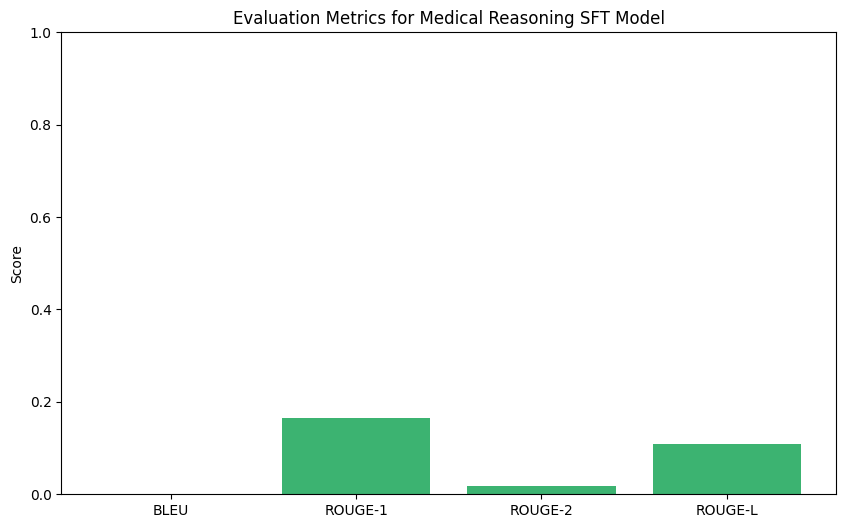

In [ ]:
# -----------------------------
# Evaluation
# -----------------------------
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

bleu_score = bleu.compute(predictions=preds, references=[[r] for r in refs])
rouge_score = rouge.compute(predictions=preds, references=refs)

print("BLEU:", bleu_score["bleu"])
print("ROUGE-1:", rouge_score["rouge1"])
print("ROUGE-2:", rouge_score["rouge2"])
print("ROUGE-L:", rouge_score["rougeL"])

# -----------------------------
# Visualization
# -----------------------------
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [
    bleu_score['bleu'],
    rouge_score['rouge1'],
    rouge_score['rouge2'],
    rouge_score['rougeL']
]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='mediumseagreen')
plt.title('Evaluation Metrics for Medical Reasoning SFT Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [ ]:
import re

def extract_final_answer(text):
    # Split by think tags if present
    if "</think>" in text:
        text = text.split("</think>")[-1]

    # Remove anything after "Follow-up Question" or similar distractions
    text = re.split(r'Follow[- ]?up|Instruction|Solution', text)[0]

    # Try to grab the last sentence or phrase
    sentences = re.split(r'\.\s+|\n+', text.strip())
    last = sentences[-1].strip()

    # Edge case: fallback to last few tokens
    if len(last.split()) < 2 and len(sentences) > 1:
        last = sentences[-2].strip()

    return last.lower()


In [ ]:
def compute_token_f1(pred, ref):
    pred_tokens = set(pred.lower().split())
    ref_tokens = set(ref.lower().split())
    overlap = pred_tokens & ref_tokens

    if not overlap:
        return 0.0

    precision = len(overlap) / len(pred_tokens)
    recall = len(overlap) / len(ref_tokens)
    return 2 * (precision * recall) / (precision + recall)


In [ ]:
em_total = 0
f1_total = 0

for pred, ref in zip(preds, refs):
    if pred.strip() == ref.strip():
        em_total += 1
    f1_total += compute_token_f1(pred, ref)

num_samples = len(preds)
accuracy = em_total / num_samples
avg_f1 = f1_total / num_samples

print(f"✅ Final Answer Accuracy (Exact Match): {accuracy:.3f}")
print(f"✅ Token-level F1 Score: {avg_f1:.3f}")


✅ Final Answer Accuracy (Exact Match): 0.000
✅ Token-level F1 Score: 0.132


In [ ]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from evaluate import load

bertscore = load("bertscore")

# Run BERTScore
results = bertscore.compute(predictions=preds, references=refs, lang="en")

# Print mean scores
print(f"✅ BERTScore F1:      {sum(results['f1']) / len(results['f1']):.3f}")
print(f"🧠 BERTScore Precision: {sum(results['precision']) / len(results['precision']):.3f}")
print(f"📥 BERTScore Recall:    {sum(results['recall']) / len(results['recall']):.3f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERTScore F1:      0.811
🧠 BERTScore Precision: 0.808
📥 BERTScore Recall:    0.815


#Base Model - Phi3

In [ ]:
model_id = "microsoft/Phi-3-mini-4k-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token  # avoid padding errors

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    trust_remote_code=True
)

model.eval()



# -----------------------------
# Inference Function
# -----------------------------
def generate_response_base(question, base_model):
    inference_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>

"""

    inputs = tokenizer(inference_prompt_style, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = base_model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=300,
            do_sample=False,
            use_cache=False,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded.split("### Response:")[-1].strip()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# -----------------------------
# Collect Predictions & References
# -----------------------------
preds_phi_base = []
refs_phi_base = []

for example in dataset:
    question = example["Question"]
    reference = example["Response"]
    response = generate_response_base(question,base_model)
    preds_phi_base.append(response)
    refs_phi_base.append(reference)

In [ ]:
# Run BERTScore
results = bertscore.compute(predictions=preds_phi_base, references=refs_phi_base, lang="en")

# Print mean scores
print(f"✅ BERTScore F1:      {sum(results['f1']) / len(results['f1']):.3f}")
print(f"🧠 BERTScore Precision: {sum(results['precision']) / len(results['precision']):.3f}")
print(f"📥 BERTScore Recall:    {sum(results['recall']) / len(results['recall']):.3f}")

✅ BERTScore F1:      0.820
🧠 BERTScore Precision: 0.826
📥 BERTScore Recall:    0.814


In [ ]:
pred

"<think>\n\nAlright, let's think about this. We're looking at a case where a patient has a fever and a cough, and they're also experiencing some chest pain. That's a pretty classic trio of symptoms that could point to a respiratory infection.\n\nNow, when I think about respiratory infections, I immediately consider the usual suspects. We've got the common cold, influenza, and then there's pneumonia. But wait, pneumonia usually comes with more severe symptoms like high fever and a lot of chest pain.\n\nHmm, let's dig deeper. The fever and cough are definitely there, but the chest pain is a bit of a red flag. It's not just any chest pain; it's described as sharp and pleuritic. That's a clue. Pleuritic pain often suggests something like pleurisy, which is inflammation of the lining of the lungs.\n\nOh, and the fever and cough are pretty consistent with a viral infection. But the sharp chest pain is more like something you'd see with a bacterial infection.\n\nLet's not forget about the pos